## 1.数据准备

### 1.1 加载训练集

In [5]:
import numpy as np
import os
from keras.datasets.cifar import load_batch

## 加载数据集cifar10里面的训练集
def load_train_dataset(dirPath='../resources/cifar-10-batches-py/'):
    train_sample_quantity = 50000
    image_width = 32
    image_height = 32
    channel_quantity = 3
    train_X = np.zeros((train_sample_quantity, channel_quantity, image_width, image_height),
                       dtype='uint8')
    train_y = np.zeros((train_sample_quantity, ),
                       dtype='uint8')
    for i in range(1, 6):
        fileName = 'data_batch_%d' %i
        filePath = os.path.join(dirPath, fileName)
        startIndex = (i - 1) * 10000
        endIndex = i * 10000
        train_X[startIndex:endIndex, :, :, :], train_y[startIndex:endIndex] = load_batch(filePath)
    print('train_X矩阵转置前：', train_X.shape)
    # 从官网上下载的数据集的4个维度为样本个数n、通道数c、宽度w、高度h
    # Keras基于Tensorflow，数据的维度顺序要求：样本个数n、宽度w、高度h、通道数c，所以使用np.transpose完成矩阵转置
    train_X = train_X.transpose(0, 2, 3, 1)
    print('train_X矩阵转置后：', train_X.shape)
    return train_X, train_y

dirPath = '../resources/cifar-10-batches-py/'
train_imageData, train_y = load_train_dataset() 

train_X矩阵转置前： (50000, 3, 32, 32)
train_X矩阵转置后： (50000, 32, 32, 3)


### 1.2 加载测试集

In [6]:
# 加载数据集cifar10里面的测试集
def load_test_dataset(dirPath='../resources/cifar-10-batches-py/'):
    fileName = 'test_batch'
    filePath = os.path.join(dirPath, fileName)
    test_X, test_y = load_batch(filePath)
    print('test_X矩阵转置前：', test_X.shape)
    test_X = test_X.transpose(0, 2, 3, 1)
    print('test_X矩阵转置后：', test_X.shape)
    return test_X, test_y

dirPath = '../resources/cifar-10-batches-py/'
test_imageData, test_y = load_test_dataset() 

test_X矩阵转置前： (10000, 3, 32, 32)
test_X矩阵转置后： (10000, 32, 32, 3)


### 1.3 对类别做One-Hot编码

In [7]:
# 对类别ID做One-Hot编码
from keras.utils import to_categorical

class_quantity = 10
train_Y = to_categorical(train_y, class_quantity)
test_Y = to_categorical(test_y, class_quantity)

## 1.4 对图片像素的0-255值做归一化，并减去均值

In [8]:
train_X = train_imageData.astype('float32') / 255
test_X = test_imageData.astype('float32') / 255
pixel_mean = np.mean(train_X, axis=0)
print('pixel_mean.shape:', pixel_mean.shape)
train_X = train_X - pixel_mean
test_X = test_X - pixel_mean

pixel_mean.shape: (32, 32, 3)


## 2.使用load_model方法加载模型文件

### 2.1 加载模型

In [5]:
from keras.models import load_model
from keras.optimizers import Adam

model_filePath = '../resources/saved_models/cifar10_ResNet56v2_model.162.h5'
model = load_model(model_filePath)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### 2.2 计算训练集的准确率

In [9]:
# Score trained model on train dataset
scores = model.evaluate(train_X, train_Y, verbose=1, batch_size=1000)
print('Test loss:%.6f' %scores[0])
print('Test accuracy:%.6f' %scores[1])

50000/50000 [==============================] - 19s 383us/step
Test loss:0.145283
Test accuracy:0.997960


### 2.3 计算测试集的准确率

In [10]:
# Score trained model on test dataset
scores = model.evaluate(test_X, test_Y, verbose=1, batch_size=1000)
print('Test loss:%.6f' %scores[0])
print('Test accuracy:%.6f' %scores[1])

10000/10000 [==============================] - 3s 286us/step
Test loss:0.471307
Test accuracy:0.932900


## 3.模型测试结果可视化

### 3.1 随机选取100张图片并展示测试结果

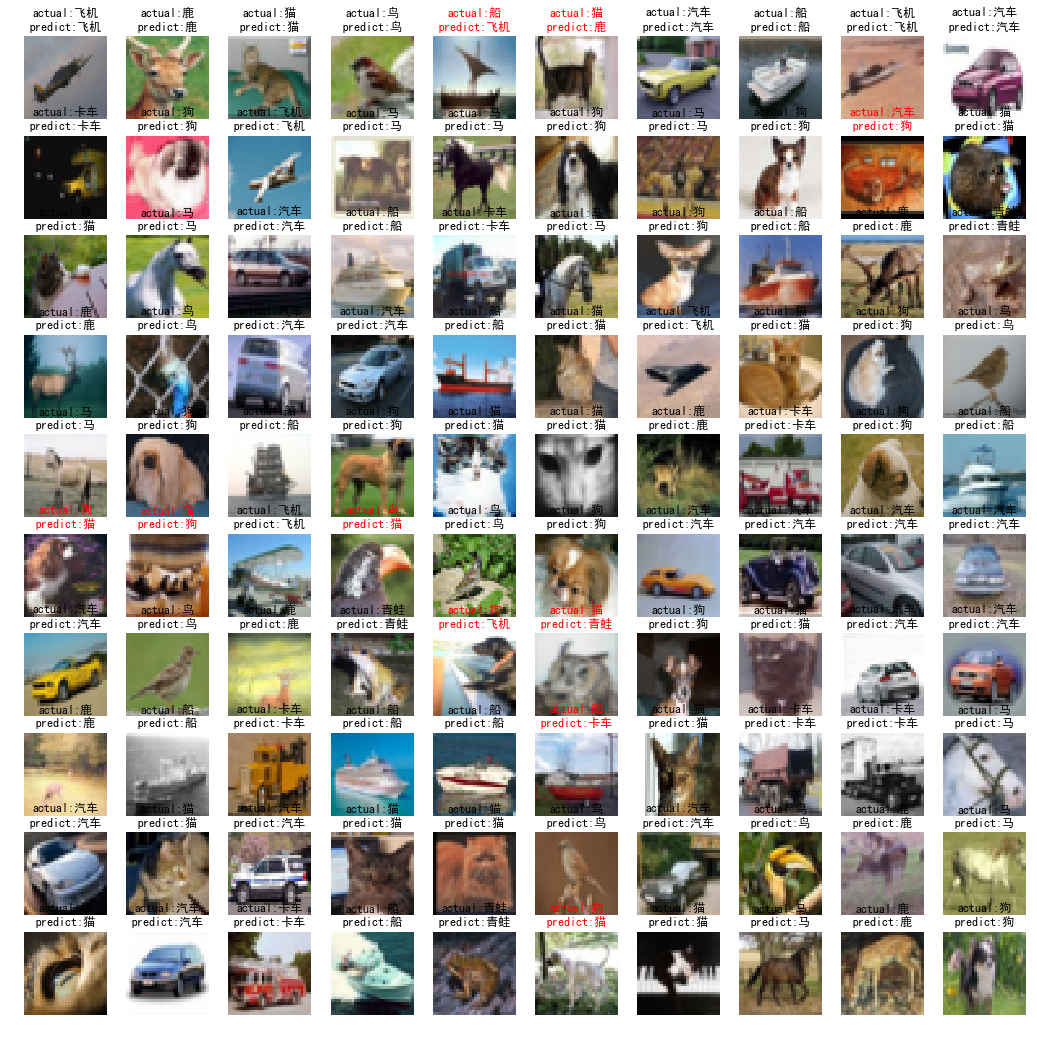

In [9]:
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
import random

def draw_image(position, image, title, isTrue):
    plt.subplot(*position)
    plt.imshow(image)
    plt.axis('off')
    if not isTrue:
        plt.title(title, color='red')
    else:
        plt.title(title)
        
def batch_draw_images(model, batch_size, test_imageData, test_X, test_y, id2name_dict):
    index_list = list(range(len(test_imageData)))
    selected_index_list = random.sample(index_list, batch_size)
    true_imageData = test_imageData[selected_index_list]
    true_X = test_X[selected_index_list]
    true_y = np.array(test_y)[selected_index_list]
    predict_Y = model.predict(true_X)
    predict_y = np.argmax(predict_Y, axis=1)
    row_number = math.ceil(batch_size ** 0.5)
    column_number = row_number
    plt.figure(figsize=(row_number+8, column_number+8))
    for i in range(row_number):
        for j in range(column_number):
            index = i * column_number + j
            if index < batch_size:
                position = (row_number, column_number, index+1)
                image = true_imageData[index]
                actual_classId = true_y[index]
                predict_classId = predict_y[index]
                isTrue = actual_classId==predict_classId
                actual_className = id2name_dict[actual_classId]
                predict_className = id2name_dict[predict_classId]
                title = 'actual:%s\npredict:%s' %(actual_className, predict_className)
                draw_image(position, image, title, isTrue)

batch_size = 100    
className_list = ['飞机', '汽车', '鸟', '猫', '鹿', '狗', '青蛙', '马', '船', '卡车']
id2name_dict = {a:b for a, b in enumerate(className_list)}
batch_draw_images(model, batch_size, test_imageData, test_X, test_y, id2name_dict)
plt.show()

### 3.2 随机选取100张图片的同时，要求10个类别，每个类别取10张

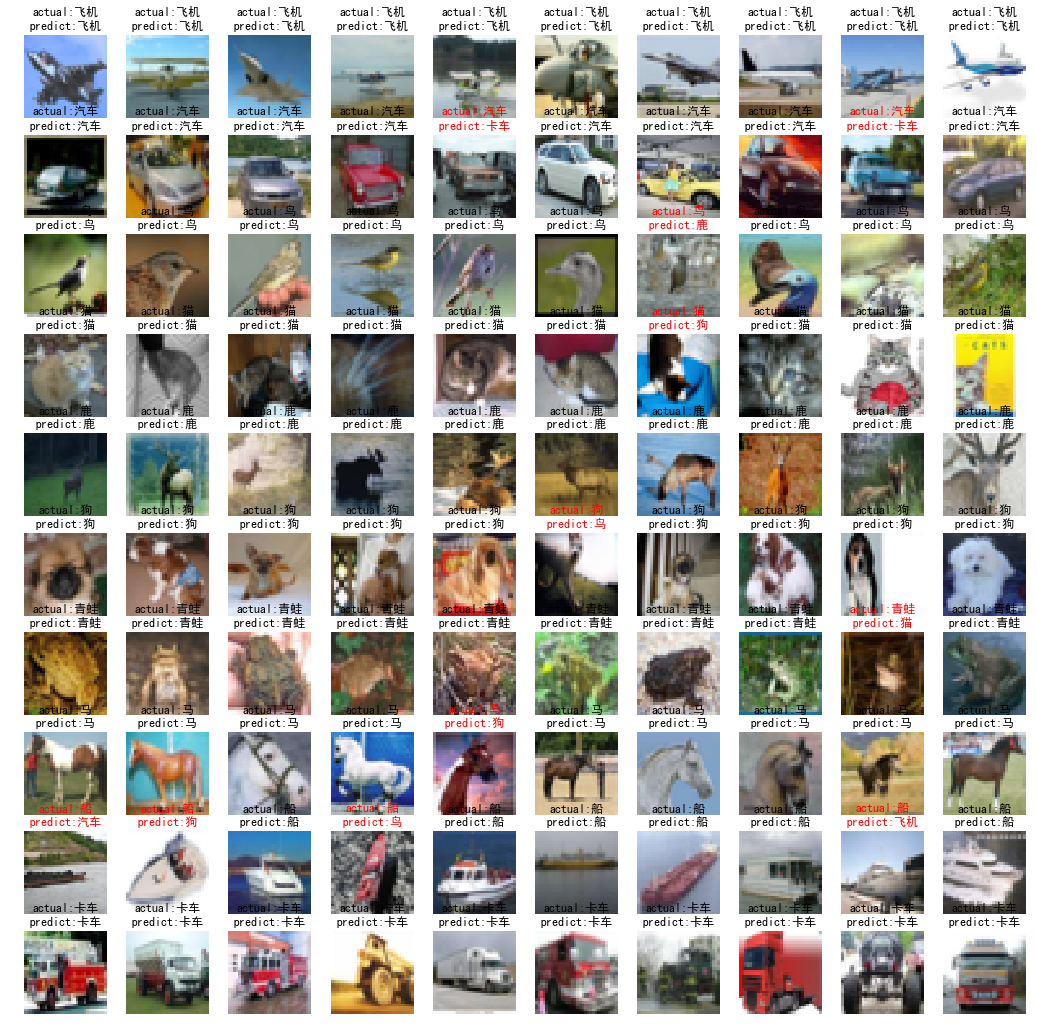

In [10]:
def get_selectedIndexList(test_y, batch_size):
    assert batch_size % 10 == 0, 'batch_size must be times by 10, or you change function get_selectedIndexList'
    column_number = int(batch_size / 10)
    classId_ndarray = np.unique(test_y)
    selected_index_list = []
    for i, classId in enumerate(classId_ndarray):
        index_ndarray = np.where(test_y==classId)[0]
        selected_index_ndarray = np.random.choice(index_ndarray, column_number)
        selected_index_list.extend(selected_index_ndarray.tolist())
    return selected_index_list    
        
def batch_draw_images_2(model, selected_index_list, test_imageData, test_X, test_y, id2name_dict):
    true_imageData = test_imageData[selected_index_list]
    true_X = test_X[selected_index_list]
    true_y = np.array(test_y)[selected_index_list]
    predict_Y = model.predict(true_X)
    predict_y = np.argmax(predict_Y, axis=1)
    row_number = math.ceil(batch_size ** 0.5)
    column_number = row_number
    plt.figure(figsize=(row_number+8, column_number+8))
    for i in range(row_number):
        for j in range(column_number):
            index = i * column_number + j
            if index < batch_size:
                position = (row_number, column_number, index+1)
                image = true_imageData[index]
                actual_classId = true_y[index]
                predict_classId = predict_y[index]
                isTrue = actual_classId==predict_classId
                actual_className = id2name_dict[actual_classId]
                predict_className = id2name_dict[predict_classId]
                title = 'actual:%s\npredict:%s' %(actual_className, predict_className)
                draw_image(position, image, title, isTrue)

batch_size = 100     
className_list = ['飞机', '汽车', '鸟', '猫', '鹿', '狗', '青蛙', '马', '船', '卡车']
id2name_dict = {a:b for a, b in enumerate(className_list)}
selected_index_list = get_selectedIndexList(test_y, batch_size)
batch_draw_images_2(model, selected_index_list, test_imageData, test_X, test_y, id2name_dict)
plt.show()

## 4.Keras中权重文件的读写

### 4.1 使用save_weights方法保存权重文件

In [ ]:
weights_h5FilePath = '../resources/saved_models/resnet56v2_weights.h5'
model.save_weights(weights_h5FilePath)

### 4.2 使用load_weights方法加载权重文件

In [3]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v2(input_shape, depth, num_classes=10):
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [4]:
input_shape = (32, 32, 3)
depth = 56
model = resnet_v2(input_shape, depth)
weights_h5FilePath = '../resources/saved_models/resnet56v2_weights.h5'
model.load_weights(weights_h5FilePath)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])